In [1]:
# digit recognizer 0 to 9 using mnist Dataset

In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time
from sklearn.metrics import confusion_matrix

In [3]:
# MNIST = datasets.mnist('data.csvmnist_trainset')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

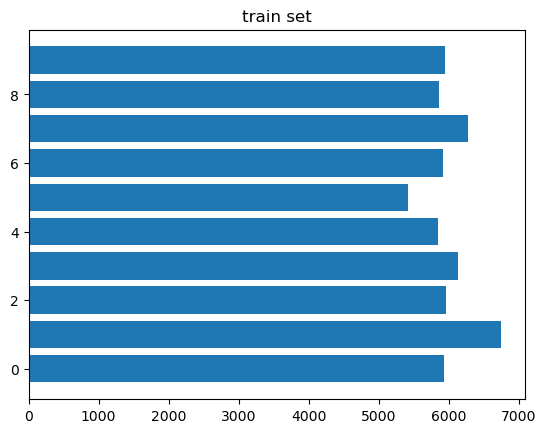

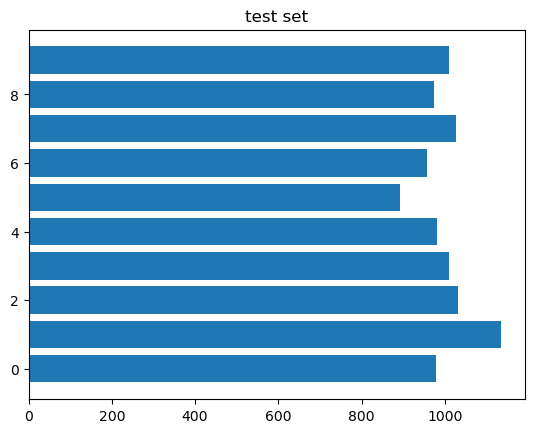

In [4]:
train_count = np.unique(mnist_trainset.targets.numpy(), return_counts=True)
test_count = np.unique(mnist_testset.targets.numpy(), return_counts=True)

plt.barh(y=train_count[0], width=train_count[1])
plt.title('train set')
plt.show()

plt.barh(y=test_count[0], width=test_count[1])
plt.title('test set')
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
X_train = mnist_trainset.data.to(device)
X_train = X_train.float()

y_train = mnist_trainset.targets.to(device)

X_test = mnist_testset.data.to(device)
X_test = X_test.float()

y_test = mnist_testset.targets.to(device)

X_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

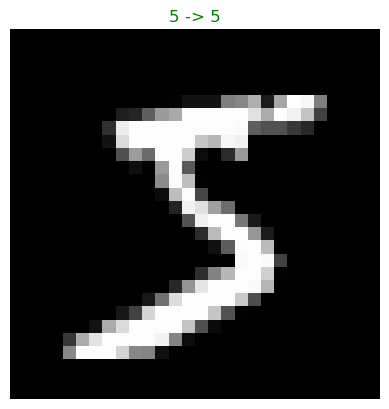

In [7]:
def show_img(X: torch.Tensor, y: torch.Tensor, pred: torch.Tensor):
    X = torch.Tensor.cpu(X).reshape(-1, 28, 28, 1)
    y = torch.Tensor.cpu(y).reshape(-1, 1)
    pred = torch.Tensor.cpu(pred).reshape(-1, 1)
    rows = columns = math.ceil(X.size(dim=0)**0.5)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.size(dim=0)):
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(X[i] , cmap='grey')
        plt.title(f'{y[i].item()} -> {pred[i].item()}', color=('red' if y[i].item()!=pred[i].item() else 'green'))
    plt.show()

show_img(X_train[0], y_train[0], y_train[0])

In [8]:
class Model1(nn.Module): # without convolution layers
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        output = input.view(-1, 28*28)
        output = self.l1(output)
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [9]:
class Model2(nn.Module): # using CNN's 
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1
        
        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16
        
        output = output.view(-1, 16 * 4*4) # flattening
        # size = X * 256

        output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [10]:
def train(model: nn.Module, epochs: int, learning_rate: float) -> nn.Module:
    print(model.parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    for i in range(epochs):
        pred = model(X_train)
        loss = criterion(pred, y_train)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i % (epochs//10)==0):
            with torch.no_grad():
                pred_test = model(X_test)
                pred_test = torch.argmax(pred_test, dim=1)
            
                correct = (pred_test==y_test).sum().item()
                acc = 100 * (correct/y_test.size(dim=0))
                print(f'epoch = {i}/{epochs}')
                print(f'loss = {loss.item():.3f}')
                print(f'accuracy = {acc:.3f}', end=2*'\n')

    
    with torch.no_grad(): # not using evaluation(test) for gradient descent
        pred_test = model(X_test)
        pred_test = torch.argmax(pred_test, dim=1)
    
        correct = (pred_test==y_test).sum().item()
        acc = 100 * (correct/y_test.size(dim=0))
        print(f'epoch = {i+1}/{epochs}')
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2*'\n')
        
    end_time = time.time()
    print(f'total {end_time-start_time:.3f} seconds on {device}.')
    return model

In [11]:
epochs = 200
learning_rate = 0.0005

model1 = Model1(28*28, 40, 20).to(device)
model2 = Model2(4*4*16, 120, 80).to(device)

print("model 1")
train(model1, epochs=epochs, learning_rate=learning_rate)

print('\n'*5)

print("model 2")
model = train(model2, epochs=epochs, learning_rate=learning_rate) # saving trained conv-model

model 1
<bound method Module.parameters of Model1(
  (l1): Linear(in_features=784, out_features=40, bias=True)
  (l2): Linear(in_features=40, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)>
epoch = 0/200
loss = 2.460
accuracy = 11.750

epoch = 20/200
loss = 1.897
accuracy = 51.530

epoch = 40/200
loss = 1.826
accuracy = 60.920

epoch = 60/200
loss = 1.734
accuracy = 70.610

epoch = 80/200
loss = 1.706
accuracy = 71.130

epoch = 100/200
loss = 1.695
accuracy = 72.180

epoch = 120/200
loss = 1.688
accuracy = 72.970

epoch = 140/200
loss = 1.683
accuracy = 73.500

epoch = 160/200
loss = 1.680
accuracy = 74.090

epoch = 180/200
loss = 1.676
accuracy = 74.830

epoch = 200/200
loss = 1.672
accuracy = 75.790

total 2.525 seconds on cuda.






model 2
<bound method Module.parameters of Model2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (po

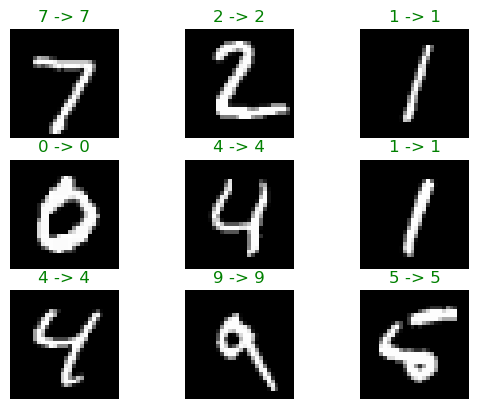

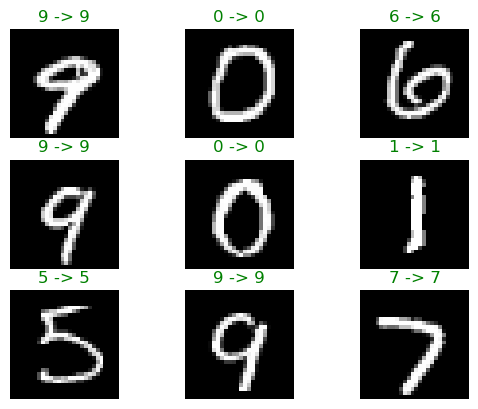

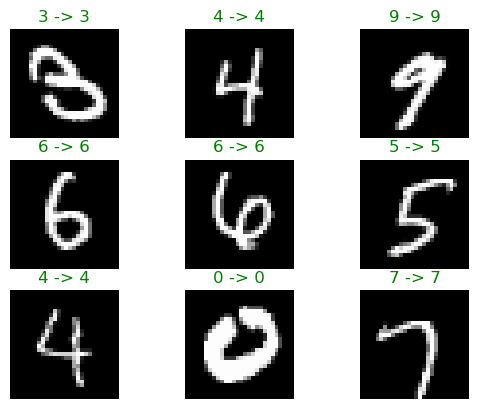

In [12]:
pred_test = model(X_test)
pred_test = torch.argmax(pred_test, dim=1)

n_sample = 3
sample_size = 9
for i in range(0, sample_size*n_sample, sample_size): # (sample_size*n_sample) instances which the model predicted wrongly
    show_img(X_test[i:i+sample_size], y_test[i:i+sample_size],pred_test[i:i+sample_size])

There were 376 incorrect predictions out of 10000 tests.


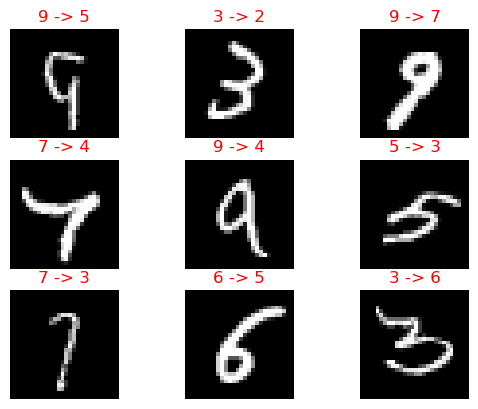

In [13]:
wrong_pred_index = (pred_test!=y_test)
wrong_preds = (X_test[wrong_pred_index], y_test[wrong_pred_index], pred_test[wrong_pred_index])
print(f'There were {wrong_preds[0].size(dim=0)} incorrect predictions out of {X_test.size(dim=0)} tests.')

n_sample = 1
sample_size = 9
for i in range(0, sample_size*n_sample, sample_size): # 10 instances which the model predicted wrongly
    show_img(wrong_preds[0][i:i+sample_size], wrong_preds[1][i:i+sample_size], wrong_preds[2][i:i+sample_size])

In [14]:
y_test = torch.Tensor.cpu(y_test).numpy()
pred_test = torch.Tensor.cpu(pred_test).numpy()

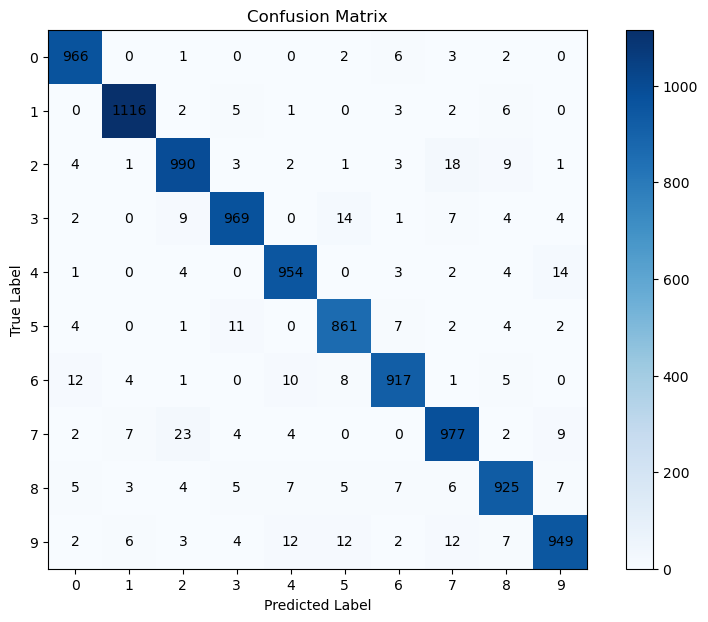

In [15]:
# 10*10 map
conf_matrix = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(10,7))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
for i in range(10):
    for j in range(10):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center')
plt.show()

0 : 98.6% accuracy
1 : 98.3% accuracy
2 : 95.9% accuracy
3 : 95.9% accuracy
4 : 97.1% accuracy
5 : 96.5% accuracy
6 : 95.7% accuracy
7 : 95.0% accuracy
8 : 95.0% accuracy
9 : 94.1% accuracy


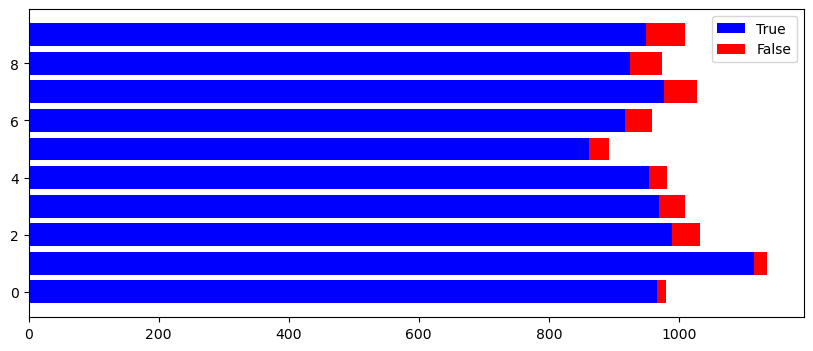

In [16]:
labels = [i for i in range(0,10)]
dic = {i:[0,0] for i in range(0,10)}
for i in range(y_test.size):
    if(y_test[i]==pred_test[i]):
        dic[y_test[i]][0]+=1
    else:
        dic[y_test[i]][1]+=1
counts = list(dic.values())
for i in dic:
    print(f'{i} : {(dic[i][0]/(dic[i][1]+dic[i][0])*100):.1f}% accuracy')
right_count = []
wrong_count = []
for i in counts:
    right_count.append(i[0])
    wrong_count.append(i[1])
plt.figure(figsize=(10,4))
plt.barh(y=labels, width=right_count, color="blue")
plt.barh(y=labels, width=wrong_count, left=right_count, color="red")
plt.legend(['True', 'False'], loc='upper right')
plt.show()

In [17]:
# saving model
FILE = 'model.pth'
torch.save(model, FILE)